In [1]:
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

from keras.utils import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

# figure size in inches
#rcParams['figure.figsize'] = 10,6

In [2]:
def rle_decode(rle_mask, shape):

    """
    Decode run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    rle_mask (str): Run-length encoded segmentation mask string
    shape (tuple of shape (2)): Height and width of the mask

    Returns
    -------
    mask (numpy.ndarray of shape (height, width)): Decoded 2d segmentation mask
    """

    rle_mask = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
    starts -= 1
    ends = starts + lengths

    mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    mask = mask.reshape(shape[0], shape[1])
    return mask.T

def show_mask(id: int)-> None:
    im = Image.open(os.path.join("train_images",str(id)+".tiff"))
    im_mask = df.loc[df["id"]==id]['rle'].iloc[0]
    im_decode = rle_decode(im_mask, im.size)
    im_decode *= 255
    img_decode = Image.fromarray(im_decode,mode="L")

In [3]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

#input_layer = Input((img_size_target, img_size_target, 1))
#output_layer = build_model(input_layer, 16)


In [25]:
df = pd.read_csv("my_train.csv",index_col="id")
df['organ'] = pd.Categorical(df['organ'], ['prostate', 'spleen', 'lung', 'kidney', 'largeintestine'])

#train, dev, test = np.split(df.sample(frac=1, random_state=42), 
#                       [int(.8*len(df)), int(.9*len(df))])

### Image and mask resize to 512x512 pixels

In [102]:
def image_resize(s):
    newsize = (512,512)
    s["image"] = np.array(Image.open(os.path.join("train_images",str(s.name)+".tiff")).resize(newsize).convert("L")) /255
    s["mask"] = np.array(Image.fromarray(rle_decode(s["rle"],(s["img_height"],s["img_width"])*255)).resize(newsize).convert("L"))
    return s

In [104]:
df = df.apply(image_resize,axis =1)

In [120]:
img_size_target = 512
train_df, valid_df, test_df = np.split(df.sample(frac=1, random_state=42), 
                       [int(.8*len(df)), int(.9*len(df))])

x_train =  np.array(train_df["image"].tolist()).reshape(-1, img_size_target, img_size_target, 1)
x_valid =  np.array(valid_df["image"].tolist()).reshape(-1, img_size_target, img_size_target, 1)

y_train =  np.array(train_df["mask"].tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_valid =  np.array(valid_df["mask"].tolist()).reshape(-1, img_size_target, img_size_target, 1)

In [121]:

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_19[0][0]']              
                                )                                                           

In [123]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 10
batch_size = 3

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.9032 
Epoch 1: val_loss improved from inf to 0.45205, saving model to .\keras.model


INFO:tensorflow:Assets written to: .\keras.model\assets


INFO:tensorflow:Assets written to: .\keras.model\assets


9/9 [==============================] - 382s 42s/step - loss: 0.7027 - accuracy: 0.9032 - val_loss: 0.4521 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.9038 
Epoch 2: val_loss improved from 0.45205 to 0.33819, saving model to .\keras.model


INFO:tensorflow:Assets written to: .\keras.model\assets


INFO:tensorflow:Assets written to: .\keras.model\assets


9/9 [==============================] - 360s 40s/step - loss: 0.3793 - accuracy: 0.9038 - val_loss: 0.3382 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 3/10
9/9 [==============================] - ETA: 0s - loss: 0.3054 - accuracy: 0.9038 
Epoch 3: val_loss did not improve from 0.33819
9/9 [==============================] - 356s 39s/step - loss: 0.3054 - accuracy: 0.9038 - val_loss: 0.3618 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 4/10
9/9 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.9038 
Epoch 4: val_loss did not improve from 0.33819
9/9 [==============================] - 364s 41s/step - loss: 0.3100 - accuracy: 0.9038 - val_loss: 0.3393 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 5/10
9/9 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.9038 
Epoch 5: val_loss improved from 0.33819 to 0.33336, saving model to .\keras.model


INFO:tensorflow:Assets written to: .\keras.model\assets


INFO:tensorflow:Assets written to: .\keras.model\assets


9/9 [==============================] - 380s 42s/step - loss: 0.3021 - accuracy: 0.9038 - val_loss: 0.3334 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 6/10
9/9 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.9038 
Epoch 6: val_loss did not improve from 0.33336
9/9 [==============================] - 385s 43s/step - loss: 0.3015 - accuracy: 0.9038 - val_loss: 0.3337 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 7/10
9/9 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.9038 
Epoch 7: val_loss did not improve from 0.33336
9/9 [==============================] - 372s 41s/step - loss: 0.2996 - accuracy: 0.9038 - val_loss: 0.3356 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 8/10
9/9 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.9038 
Epoch 8: val_loss did not improve from 0.33336
9/9 [==============================] - 374s 42s/step - loss: 0.2995 - accuracy: 0.9038 - val_loss: 0.3343 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 9/10
9

INFO:tensorflow:Assets written to: .\keras.model\assets


INFO:tensorflow:Assets written to: .\keras.model\assets


9/9 [==============================] - 397s 44s/step - loss: 0.2987 - accuracy: 0.9038 - val_loss: 0.3326 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 10/10
9/9 [==============================] - ETA: 0s - loss: 0.2980 - accuracy: 0.9038 
Epoch 10: val_loss improved from 0.33259 to 0.33090, saving model to .\keras.model


INFO:tensorflow:Assets written to: .\keras.model\assets


INFO:tensorflow:Assets written to: .\keras.model\assets


9/9 [==============================] - 401s 45s/step - loss: 0.2980 - accuracy: 0.9038 - val_loss: 0.3309 - val_accuracy: 0.8853 - lr: 0.0010


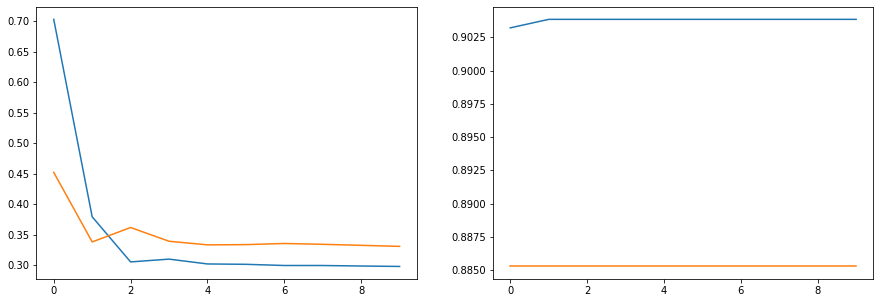

In [127]:
fig, (ax_loss, ax_accu) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_accu.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax_accu.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")

In [126]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])